## One point crossover

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random



# Population
num_demes = 100
deme_size = 10
g = 101  # Some parameter that shows current generation and algorithmic progress (as g increases pc decreases)
c = 2     # Constant parameter which is greater than 1
xi = 0.1  # Positive constant close to zero but a little greater
N = 400
B = 20
k = 20
peaks = 2 #T


# To calculate the hamming distance
def hamming_distance(array1,array2):
  if len(array1) != len(array2):
        raise ValueError("Arrays must be of equal length")

  distance = np.sum(array1 != array2)
  return distance

# Sub block fitness
def sub_block_fitness(block,peaks,target_strings,W):
    fitness = 0
    for i in range(peaks):
        dist = hamming_distance(block, target_strings[i])
        if dist == 0:
            fitness += W[i]
        else:
            fitness += 1/(1 + dist)

    return fitness



# Calculate the full fitness of the genotype
def genotype_fitness(genotype,N,k,peaks,target_strings,W):
  left_pointer = 0
  right_pointer = k
  fitness = 0
  for i in range(k):
    block = genotype[left_pointer:right_pointer]
    left_pointer += k
    right_pointer += k
    block_fitness = sub_block_fitness(block,peaks,target_strings,W)
    fitness += block_fitness

  return fitness

# calculate mutation probability
def mutation_probability(N):
    pm = 1/N
    return pm

def crossover_probability(N, g, c, xi, g_max):
    # Calculate the term O(1/N)
    term = 1 / N
    # Check if g is greater than or equal to c * log(sqrt(N))
    if g >= c * np.log(np.sqrt(N)):
        # Calculate the lower and upper bounds for pc
        lower_bound = xi
        upper_bound = 1 - xi

        # Linearly decrease pc as g increases
        pc = max(lower_bound * (1 - g / g_max), 1 - term)
        pc = min(upper_bound * (1 - g / g_max), pc)
    else:
        pc = 0
    return pc

# Example usage
g_max = 100  # Maximum value of g
crossover_probabilities = [crossover_probability(N, g, c, xi, g_max) for g in range(1, g_max + 1)]

# Mutate the bits
def mutate(genotype):
    mutated_genotype = np.copy(genotype)
    for i in range(len(mutated_genotype)):
        if np.random.random() < 1/math.sqrt(N):
            mutated_genotype[i] = 1 - mutated_genotype[i]  # Flip the bit
    return mutated_genotype

# Perform 2 point crossover
def two_point_crossover(parent1, parent2, crossover_point_1,crossover_point_2):
    child1 = np.concatenate((parent1[:crossover_point_1], parent2[crossover_point_1:crossover_point_2],parent1[crossover_point_2:]))
    child2 = np.concatenate((parent2[:crossover_point_1], parent1[crossover_point_1:crossover_point_2],parent2[crossover_point_2:],))
    return child1, child2

def one_point_crossover(parent1, parent2,crossover_point):
  child1 = np.concatenate((parent1[:crossover_point],parent1[crossover_point:]))
  child2 = np.concatenate((parent2[:crossover_point],parent2[crossover_point:],))
  return child1,child2

def uniform_crossover(parent1,parent2):
  child = np.array()
  for i in range(len(parent1)):
    if random.random() < 0.5:
      child = np.concatenate((parent1[i]))
    else:
      child = np.concatenate((parent2[i]))
  return child

# evaluate the best child from the 2 point crossover
def evaluate_best_child(child1,child2,N,k,peaks,target_strings,W):
  if genotype_fitness(child1, N, k,peaks,target_strings,W) >= genotype_fitness(child2, N, k,peaks,target_strings,W):
    return child1
  else:
    return child2

# select replacement for offspring
def select_replacement(population, offspring, N, k,peaks,target_strings,W):
    min_fitness = min([genotype_fitness(individual, N, k,peaks,target_strings,W) for individual in population])

    if genotype_fitness(offspring, N, k,peaks,target_strings,W) >= min_fitness:
        min_fitness_indices = [i for i, ind in enumerate(population) if genotype_fitness(ind, N, k,peaks,target_strings,W) == min_fitness]
        idx_to_replace = np.random.choice(min_fitness_indices)
        population[idx_to_replace] = offspring
    else:
       # If the offspring's fitness is not greater than or equal to the minimum fitness,
        # simply include the offspring in the population without replacing any individual
        population = np.append(population, [offspring], axis=0)
    return population

def average_population_fitness(population,N,k,peaks,target_strings,W):
  demes_average_fitness = 0
  for current_deme in population:
    current_deme_fitness = 0
    for current_genotype in current_deme:
      current_deme_fitness += genotype_fitness(current_genotype,N,k,peaks,target_strings,W)

    demes_average_fitness += current_deme_fitness

  return demes_average_fitness/100

# Population
num_demes = 100
deme_size = 10
g = 101  # Some parameter that shows current generation and algorithmic progress (as g increases pc decreases)
c = 2     # Constant parameter which is greater than 1
xi = 0.1  # Positive constant close to zero but a little greater
N = 400
B = 20
k = 20
peaks = 2 #T


mutation_rate = mutation_probability(N)
pc = crossover_probability(N, g, c, xi,g_max) # crossover rate
migration_rate = 0.0004  # On average one individual in every 2.5 generations is a migrant from another deme

# Getting Target Strings
t1 = np.array([1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0])
t2 = np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])

target_strings = np.vstack((t1, t2))

# Weights
W = [1,10]


#setting population
population = []
for i in range(num_demes):
  current_deme = np.random.randint(2, size=(deme_size, N))
  population.append(current_deme)

#rank-based selection
def rank_based_selection(population, selection_pressure=2):
    
    population_size = len(population)
    rank_scores = [i + 1 for i in range(population_size)]  # Assign ranks to individuals
    total_rank_score = sum(rank_scores)
    selection_probabilities = [rank_score / total_rank_score for rank_score in rank_scores]
    
    selected_indices = np.random.choice(range(population_size), size=population_size, replace=True, p=selection_probabilities)
    
    return selected_indices


average_fitnesses = []
x_labels = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
for e in range(g):
    if e in x_labels:
        current_generation_fitness = average_population_fitness(population, N, k, peaks, target_strings, W)
        average_fitnesses.append(current_generation_fitness)
    # EA for each deme
    pc = crossover_probabilities[e - 1]
    for deme in range(num_demes):
        # EA for each deme
        deme_population = population[deme]
        # Perform rank-based selection
        fitness_scores = [genotype_fitness(individual, N, k, peaks, target_strings, W) for individual in deme_population]
        ranked_indices = np.argsort(fitness_scores)[::-1]  # Sort indices by fitness in descending order
        ranked_population = [deme_population[i] for i in ranked_indices]
        # Apply rank-based selection
        selected_indices = rank_based_selection(ranked_population)
        selected_individuals = [deme_population[i] for i in selected_indices]
        
        for mu in range(deme_size):
            xi = selected_individuals[random.randint(0, len(selected_individuals) - 1)]
            i = random.randint(0, len(selected_individuals) - 1)
            j = random.randint(0, len(selected_individuals) - 1)
            if random.random() < pc:
                if random.random() > migration_rate:
                    xj = selected_individuals[j]  # Select xj directly from selected_individuals
                else:
                    new_deme = random.randint(0, num_demes - 1)
                    new_deme_population = population[new_deme]
                    xj = new_deme_population[random.randint(0, len(new_deme_population) - 1)]  # Select xj from the population of the new deme
                    
                crossover_point = random.randint(0, len(xi) - 1)  # Choose a random crossover point
                child1, child2 = one_point_crossover(xi, xj, crossover_point)
                offspring = evaluate_best_child(child1, child2, N, k, peaks, target_strings, W)
            else:
                offspring = mutate(xi)

            deme_population = select_replacement(deme_population, offspring, N, k, peaks, target_strings, W)

        population[deme] = deme_population



print(average_fitnesses)
plt.figure(figsize=(10, 6))
plt.plot(x_labels, average_fitnesses )
plt.title('Average Fitness per Generation')
plt.xlabel('Generation')
plt.ylabel('Average Fitness')
plt.grid(True)
plt.show()

## Random mutation hill climber

In [9]:
import numpy as np
import random

# Define functions for genotype fitness evaluation
def hamming_distance(array1, array2):
    if len(array1) != len(array2):
        raise ValueError("Arrays must be of equal length")
    distance = np.sum(array1 != array2)
    return distance

def sub_block_fitness(block, peaks, target_strings, W):
    fitness = 0
    for i in range(peaks):
        
        dist = hamming_distance(block, target_strings[i])
        if dist == 0:
            fitness += W[i]
        else:
            fitness += 1 / (1 + dist)
    return fitness

def genotype_fitness(genotype, k, peaks, target_strings, W):
    fitness = 0
    block_size = len(genotype) // 20  # Calculate the size of each block based on genotype length
    for i in range(peaks):
        left_pointer = i * block_size
        right_pointer = left_pointer + block_size
        block = genotype[left_pointer:right_pointer]
        block_fitness = sub_block_fitness(block, peaks, target_strings, W)
        fitness += block_fitness
    return fitness

def average_population_fitness(population, k, peaks, target_strings, W):
    total_fitness = 0
    for deme in population:
        deme_fitness = 0
        for individual in deme:
            deme_fitness += genotype_fitness(individual, k, peaks, target_strings, W)
        total_fitness += deme_fitness
    return total_fitness / (num_demes * deme_size)

def rank_based_selection(population, selection_pressure=2):
    population_size = len(population)
    rank_scores = [i + 1 for i in range(population_size)]
    total_rank_score = sum(rank_scores)
    selection_probabilities = [rank_score / total_rank_score for rank_score in rank_scores]
    selected_indices = np.random.choice(range(population_size), size=population_size, replace=True, p=selection_probabilities)
    return selected_indices

def select_replacement(population, offspring, k, peaks, target_strings, W):
    min_fitness = min([genotype_fitness(individual, k, peaks, target_strings, W) for individual in population])

    if genotype_fitness(offspring, k, peaks, target_strings, W) >= min_fitness:
        min_fitness_indices = [i for i, ind in enumerate(population) if genotype_fitness(ind, k, peaks, target_strings, W) == min_fitness]
        idx_to_replace = np.random.choice(min_fitness_indices)
        population[idx_to_replace] = offspring
    return population

# Mutation hill climber function
def mutation_hill_climber(N, mutation_rate, k, peaks, target_strings, W, num_epochs=100, print_interval=10):
    population = np.random.randint(2, size=(num_demes, deme_size, N))
    
    for epoch in range(1, num_epochs + 1):
        # Perform mutation hill climbing
        for deme in range(num_demes):
            deme_population = population[deme]
            selected_indices = rank_based_selection(deme_population)
            selected_individuals = [deme_population[i] for i in selected_indices]

            for mu in range(deme_size):
                xi = selected_individuals[random.randint(0, len(selected_individuals) - 1)]
                best_offspring, _ = random_mutation_hill_climber(N, mutation_rate, k, peaks, target_strings, W)
                offspring = best_offspring
                deme_population = select_replacement(deme_population, offspring, k, peaks, target_strings, W)

            population[deme] = deme_population
        
        # Print average fitness after every print_interval epochs
        if epoch % print_interval == 0:
            average_fitness = average_population_fitness(population, k, peaks, target_strings, W)
            print(f"Epoch {epoch}, Average Fitness: {average_fitness}")

# Parameters
N = 400  # Number of bits per genotype
num_demes = 100  # Number of demes
deme_size = 10  # Size of each deme
k = 20  # Bits per block
peaks = 2  # Peaks per block
mutation_rate = 20 / N  # Per-bit mutation rate
B=20
# Target strings and weights
t1 = np.array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0])
t2 = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
target_strings = np.vstack((t1, t2))
W = [1, 10]  # Weights


# Run mutation hill climber for 100 epochs
mutation_hill_climber(N, mutation_rate, k, peaks, target_strings, W, num_epochs=100, print_interval=10)


Epoch 10, Average Fitness: 0.4974599870717519
Epoch 20, Average Fitness: 0.5222348631760393
Epoch 30, Average Fitness: 0.5365943620105385
Epoch 40, Average Fitness: 0.547542480558657
Epoch 50, Average Fitness: 0.5551273512435275
Epoch 60, Average Fitness: 0.562908618587295
Epoch 70, Average Fitness: 0.568840504756681
Epoch 80, Average Fitness: 0.5843030107749151
Epoch 90, Average Fitness: 0.5893973289567329
Epoch 100, Average Fitness: 0.594431601628506


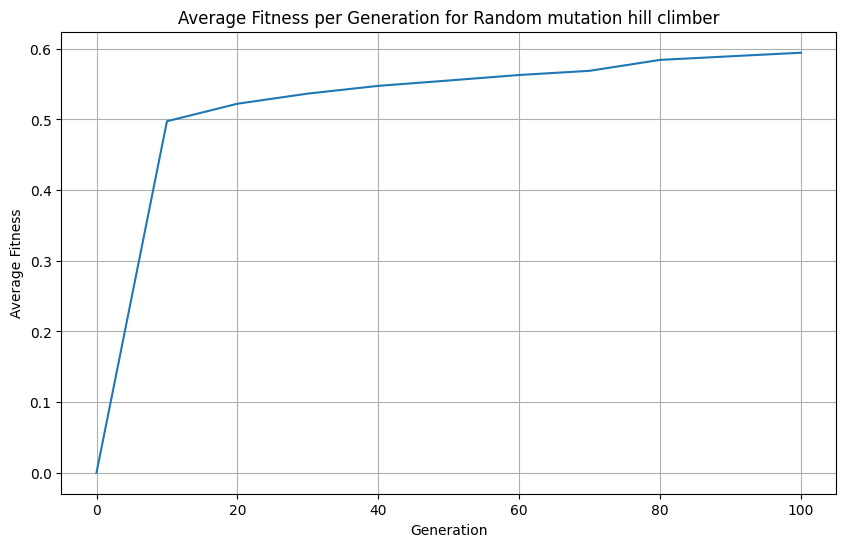

In [12]:

x_labels = [0,10,20,30,40,50,60,70,80,90,100]
average_fitnesses = [0, 0.4974599870717519, 0.5222348631760393, 0.5365943620105385, 0.547542480558657, 0.5551273512435275, 0.562908618587295, 0.568840504756681, 0.5843030107749151,0.5893973289567329, 0.594431601628506     ]
plt.figure(figsize=(10, 6))
plt.plot(x_labels, average_fitnesses )
plt.title('Average Fitness per Generation for Random mutation hill climber')
plt.xlabel('Generation')
plt.ylabel('Average Fitness')
plt.grid(True)
plt.show()

## Macro Mutation hill climber

In [13]:
import numpy as np
import random

# Define functions for genotype fitness evaluation
def hamming_distance(array1, array2):
    if len(array1) != len(array2):
        raise ValueError("Arrays must be of equal length")
    distance = np.sum(array1 != array2)
    return distance

def sub_block_fitness(block, peaks, target_strings, W):
    fitness = 0
    for i in range(peaks):
        
        dist = hamming_distance(block, target_strings[i])
        if dist == 0:
            fitness += W[i]
        else:
            fitness += 1 / (1 + dist)
    return fitness

def genotype_fitness(genotype, k, peaks, target_strings, W):
    fitness = 0
    block_size = len(genotype) // 20  # Calculate the size of each block based on genotype length
    for i in range(peaks):
        left_pointer = i * block_size
        right_pointer = left_pointer + block_size
        block = genotype[left_pointer:right_pointer]
        block_fitness = sub_block_fitness(block, peaks, target_strings, W)
        fitness += block_fitness
    return fitness
def average_population_fitness(population, k, peaks, target_strings, W):
    total_fitness = 0
    for deme in population:
        deme_fitness = 0
        for individual in deme:
            deme_fitness += genotype_fitness(individual, k, peaks, target_strings, W)
        total_fitness += deme_fitness
    return total_fitness / (num_demes * deme_size)

def rank_based_selection(population, selection_pressure=2):
    population_size = len(population)
    rank_scores = [i + 1 for i in range(population_size)]
    total_rank_score = sum(rank_scores)
    selection_probabilities = [rank_score / total_rank_score for rank_score in rank_scores]
    selected_indices = np.random.choice(range(population_size), size=population_size, replace=True, p=selection_probabilities)
    return selected_indices

def select_replacement(population, offspring, k, peaks, target_strings, W):
    min_fitness = min([genotype_fitness(individual, k, peaks, target_strings, W) for individual in population])

    if genotype_fitness(offspring, k, peaks, target_strings, W) >= min_fitness:
        min_fitness_indices = [i for i, ind in enumerate(population) if genotype_fitness(ind, k, peaks, target_strings, W) == min_fitness]
        idx_to_replace = np.random.choice(min_fitness_indices)
        population[idx_to_replace] = offspring
    return population
def macro_mutation_hill_climber(N, k, peaks, target_strings, W, num_epochs=100, print_interval=10):
    population = np.random.randint(2, size=(num_demes, deme_size, N))
    
    for epoch in range(1, num_epochs + 1):
        # Perform macro mutation hill climbing
        for deme in range(num_demes):
            deme_population = population[deme]
            selected_indices = rank_based_selection(deme_population)
            selected_individuals = [deme_population[i] for i in selected_indices]

            for mu in range(deme_size):
                xi = selected_individuals[random.randint(0, len(selected_individuals) - 1)]
                offspring = xi.copy()  # Create a copy of the selected individual
                # Pick two inter-local positions at random
                position1 = random.randint(0, N - 1)
                position2 = random.randint(0, N - 1)
                # Ensure position1 is less than position2
                if position1 > position2:
                    position1, position2 = position2, position1
                # Randomize the bits in the section of genotype in-between these positions
                offspring[position1:position2] = np.random.randint(2, size=position2 - position1)
                deme_population = select_replacement(deme_population, offspring, k, peaks, target_strings, W)

            population[deme] = deme_population
        
        # Print average fitness after every print_interval epochs
        if epoch % print_interval == 0:
            average_fitness = average_population_fitness(population, k, peaks, target_strings, W)
            print(f"Epoch {epoch}, Average Fitness: {average_fitness}")

# Parameters
N = 400  # Number of bits per genotype
num_demes = 100  # Number of demes
deme_size = 10  # Size of each deme
k = 20  # Bits per block
peaks = 2  # Peaks per block
B = 20  # Number of blocks
mutation_rate = 20 / N  # Per-bit mutation rate
# Target strings and weights
t1 = np.array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0])
t2 = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
target_strings = np.vstack((t1, t2))
W = [1, 10]  # Weights

# Run macro mutation hill climber for 100 epochs
macro_mutation_hill_climber(N, k, peaks, target_strings, W, num_epochs=100, print_interval=10)




Epoch 10, Average Fitness: 0.5003917193917194
Epoch 20, Average Fitness: 0.5330902652902653
Epoch 30, Average Fitness: 0.5611824925074926
Epoch 40, Average Fitness: 0.5763300199800203
Epoch 50, Average Fitness: 0.5922305777555777
Epoch 60, Average Fitness: 0.7004605394605394
Epoch 70, Average Fitness: 0.8089048229548229
Epoch 80, Average Fitness: 0.8222994699744699
Epoch 90, Average Fitness: 0.8745464701964698
Epoch 100, Average Fitness: 0.9468569513819511


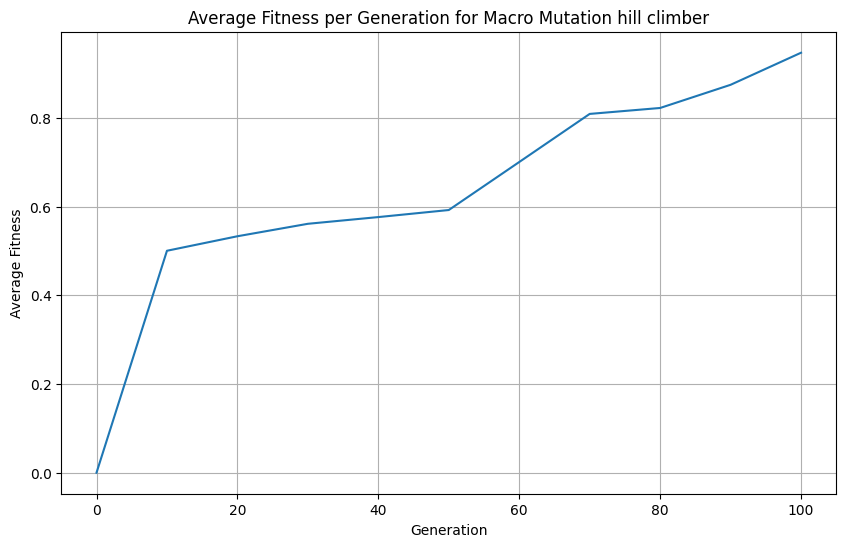

In [15]:
x_labels = [0,10,20,30,40,50,60,70,80,90,100]
average_fitnesses = [0, 0.5003917193917194,0.5330902652902653 , 0.5611824925074926, 0.5763300199800203,0.5922305777555777, 0.7004605394605394, 0.8089048229548229, 0.8222994699744699, 0.8745464701964698, 0.9468569513819511  ]
plt.figure(figsize=(10, 6))
plt.plot(x_labels, average_fitnesses )
plt.title('Average Fitness per Generation for Macro Mutation hill climber')
plt.xlabel('Generation')
plt.ylabel('Average Fitness')
plt.grid(True)
plt.show()

## Differential evolution algorithm

In [13]:

import numpy as np


# Define functions for genotype fitness evaluation
def hamming_distance(array1, array2):
    if len(array1) != len(array2):
        raise ValueError("Arrays must be of equal length")
    distance = np.sum(array1 != array2)
    return distance

def sub_block_fitness(block, peaks, target_strings, W):
    fitness = 0
    for i in range(peaks):
        
        dist = hamming_distance(block, target_strings[i])
        if dist == 0:
            fitness += W[i]
        else:
            fitness += 1 / (1 + dist)
    return fitness

def genotype_fitness(genotype, k, peaks, target_strings, W):
    fitness = 0
    block_size = len(genotype) // 20  # Calculate the size of each block based on genotype length
    for i in range(peaks):
        left_pointer = i * block_size
        right_pointer = left_pointer + block_size
        block = genotype[left_pointer:right_pointer]
        block_fitness = sub_block_fitness(block, peaks, target_strings, W)
        fitness += block_fitness
    return fitness
def average_population_fitness(population, k, peaks, target_strings, W):
    total_fitness = 0
    for deme in population:
        deme_fitness = 0
        for individual in deme:
            deme_fitness += genotype_fitness(individual, k, peaks, target_strings, W)
        total_fitness += deme_fitness
    return total_fitness / (num_demes * deme_size)

def rank_based_selection(population, selection_pressure=2):
    population_size = len(population)
    rank_scores = [i + 1 for i in range(population_size)]
    total_rank_score = sum(rank_scores)
    selection_probabilities = [rank_score / total_rank_score for rank_score in rank_scores]
    selected_indices = np.random.choice(range(population_size), size=population_size, replace=True, p=selection_probabilities)
    return selected_indices

def select_replacement(population, offspring, k, peaks, target_strings, W):
    min_fitness = min([genotype_fitness(individual, k, peaks, target_strings, W) for individual in population])

    if genotype_fitness(offspring, k, peaks, target_strings, W) >= min_fitness:
        min_fitness_indices = [i for i, ind in enumerate(population) if genotype_fitness(ind, k, peaks, target_strings, W) == min_fitness]
        idx_to_replace = np.random.choice(min_fitness_indices)
        population[idx_to_replace] = offspring
    return population

# Differential Evolution algorithm
def differential_evolution(N, k, peaks, target_strings, W, population_size=100, num_epochs=100, mutation_factor=0.5, crossover_probability=0.7, print_interval=10):
    # Initialize population
    population = np.random.randint(2, size=(population_size, N))
    
    for epoch in range(1, num_epochs + 1):
        for i in range(population_size):
            target_idx1, target_idx2, target_idx3 = np.random.choice(population_size, size=3, replace=False)
            mutant = population[target_idx1] + mutation_factor * (population[target_idx2] - population[target_idx3])
            crossover_mask = np.random.rand(N) < crossover_probability
            trial = np.where(crossover_mask, mutant, population[i])
            
            # Evaluate fitness of trial solution
            trial_fitness = genotype_fitness(trial, k, peaks, target_strings, W)
            current_fitness = genotype_fitness(population[i], k, peaks, target_strings, W)
            
            # Replace individual with trial if trial is better
            if trial_fitness > current_fitness:
                population[i] = trial
        
        # Print average fitness after every print_interval epochs
        if epoch % print_interval == 0:
            average_fitness = np.mean([genotype_fitness(individual, k, peaks, target_strings, W) for individual in population])
            print(f"Epoch {epoch}, Average Fitness: {average_fitness}")

# Parameters (same as before)
N = 400
k = 20
peaks = 2
t1 = np.array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0])
t2 = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
target_strings = np.vstack((t1, t2))
W = [1, 10]

# Run Differential Evolution for 100 epochs
differential_evolution(N, k, peaks, target_strings, W, num_epochs=100, print_interval=10)




Epoch 10, Average Fitness: 0.3935375180375181
Epoch 20, Average Fitness: 0.39958295870795874
Epoch 30, Average Fitness: 0.40204922854922853
Epoch 40, Average Fitness: 0.40382776945276944
Epoch 50, Average Fitness: 0.40643938006437996
Epoch 60, Average Fitness: 0.4097048507048507
Epoch 70, Average Fitness: 0.4097048507048507
Epoch 80, Average Fitness: 0.41030838605838604
Epoch 90, Average Fitness: 0.41347890997891
Epoch 100, Average Fitness: 0.4149691697191697


## Adaptive operator evolution

In [11]:

import numpy as np


# Define functions for genotype fitness evaluation
def hamming_distance(array1, array2):
    if len(array1) != len(array2):
        raise ValueError("Arrays must be of equal length")
    distance = np.sum(array1 != array2)
    return distance

def sub_block_fitness(block, peaks, target_strings, W):
    fitness = 0
    for i in range(peaks):
        
        dist = hamming_distance(block, target_strings[i])
        if dist == 0:
            fitness += W[i]
        else:
            fitness += 1 / (1 + dist)
    return fitness

def genotype_fitness(genotype, k, peaks, target_strings, W):
    fitness = 0
    block_size = len(genotype) // 20  # Calculate the size of each block based on genotype length
    for i in range(peaks):
        left_pointer = i * block_size
        right_pointer = left_pointer + block_size
        block = genotype[left_pointer:right_pointer]
        block_fitness = sub_block_fitness(block, peaks, target_strings, W)
        fitness += block_fitness
    return fitness
def average_population_fitness(population, k, peaks, target_strings, W):
    total_fitness = 0
    for deme in population:
        deme_fitness = 0
        for individual in deme:
            deme_fitness += genotype_fitness(individual, k, peaks, target_strings, W)
        total_fitness += deme_fitness
    return total_fitness / (num_demes * deme_size)

def rank_based_selection(population, selection_pressure=2):
    population_size = len(population)
    rank_scores = [i + 1 for i in range(population_size)]
    total_rank_score = sum(rank_scores)
    selection_probabilities = [rank_score / total_rank_score for rank_score in rank_scores]
    selected_indices = np.random.choice(range(population_size), size=population_size, replace=True, p=selection_probabilities)
    return selected_indices

def select_replacement(population, offspring, k, peaks, target_strings, W):
    min_fitness = min([genotype_fitness(individual, k, peaks, target_strings, W) for individual in population])

    if genotype_fitness(offspring, k, peaks, target_strings, W) >= min_fitness:
        min_fitness_indices = [i for i, ind in enumerate(population) if genotype_fitness(ind, k, peaks, target_strings, W) == min_fitness]
        idx_to_replace = np.random.choice(min_fitness_indices)
        population[idx_to_replace] = offspring
    return population

def adaptive_operator_evolution(N, k, peaks, target_strings, W, population_size=100, num_epochs=100, mutation_factor=0.5, crossover_probability=0.7, print_interval=10):
    # Initialize population
    population = np.random.randint(2, size=(population_size, N))
    
    mutation_factor_adaptive = mutation_factor
    crossover_probability_adaptive = crossover_probability
    
    for epoch in range(1, num_epochs + 1):
        for i in range(population_size):
            target_idx1, target_idx2, target_idx3 = np.random.choice(population_size, size=3, replace=False)
            mutant = population[target_idx1] + mutation_factor_adaptive * (population[target_idx2] - population[target_idx3])
            crossover_mask = np.random.rand(N) < crossover_probability_adaptive
            trial = np.where(crossover_mask, mutant, population[i])
            
            # Evaluate fitness of trial solution
            trial_fitness = genotype_fitness(trial, k, peaks, target_strings, W)
            current_fitness = genotype_fitness(population[i], k, peaks, target_strings, W)
            
            # Replace individual with trial if trial is better
            if trial_fitness > current_fitness:
                population[i] = trial
        
        # Update adaptive operators based on population performance
        average_fitness = np.mean([genotype_fitness(individual, k, peaks, target_strings, W) for individual in population])
        if epoch % print_interval == 0:
            print(f"Epoch {epoch}, Average Fitness: {average_fitness}")
        
        if average_fitness < 0.4:  # Example threshold for mutation factor adaptation
            mutation_factor_adaptive *= 1.2  # Increase mutation factor if average fitness is low
        elif average_fitness > 0.6:
            mutation_factor_adaptive *= 0.8  # Decrease mutation factor if average fitness is high
        
        # Similarly, adjust crossover probability based on performance
        
    # Return the final population
    return population

# Run Adaptive Operator Evolution for 100 epochs
adaptive_operator_evolution(N, k, peaks, target_strings, W, num_epochs=100, print_interval=10)


# Parameters (same as before)
N = 400
k = 20
peaks = 2
t1 = np.array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0])
t2 = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
target_strings = np.vstack((t1, t2))
W = [1, 10]





Epoch 10, Average Fitness: 0.38488822185726207
Epoch 20, Average Fitness: 0.38526705544197803
Epoch 30, Average Fitness: 0.38646549997130497
Epoch 40, Average Fitness: 0.38676117243609504
Epoch 50, Average Fitness: 0.3871404598153824
Epoch 60, Average Fitness: 0.3873557167806394
Epoch 70, Average Fitness: 0.38769724045304543
Epoch 80, Average Fitness: 0.38779980455560953
Epoch 90, Average Fitness: 0.3886615204540902
Epoch 100, Average Fitness: 0.3886852189777887


## Two point crossover

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random

# To calculate the hamming distance
def hamming_distance(array1,array2):
  if len(array1) != len(array2):
        raise ValueError("Arrays must be of equal length")

  distance = np.sum(array1 != array2)
  return distance

# Sub block fitness
def sub_block_fitness(block,peaks,target_strings,W):
    fitness = 0
    for i in range(peaks):
        dist = hamming_distance(block, target_strings[i])
        if dist == 0:
            fitness += W[i]
        else:
            fitness += 1/(1 + dist)

    return fitness

# Calculate the full fitness of the genotype
def genotype_fitness(genotype,N,k,peaks,target_strings,W):
  left_pointer = 0
  right_pointer = k
  fitness = 0
  for i in range(k):
    block = genotype[left_pointer:right_pointer]
    left_pointer += k
    right_pointer += k
    block_fitness = sub_block_fitness(block,peaks,target_strings,W)
    fitness += block_fitness

  return fitness

# calculate mutation probability
def mutation_probability(N):
    pm = 1/N
    return pm

#calculate crossover probability
def crossover_probability(N, g, c, xi):
    # Calculate the term O(1/N)
    term = 1 / N
    # Check if g is greater than or equal to c * log(sqrt(N))
    if g >= c * np.log(np.sqrt(N)):
        # Calculate the lower and upper bounds for pc
        lower_bound = xi
        upper_bound = 1 - xi

        # Ensure the crossover probability lies within the range [xi, 1 - xi]
        pc = max(lower_bound, 1 - term)
        pc = min(upper_bound, pc)
    else:
        pc = 0
    return pc

# Mutate the bits
def mutate(genotype):
    mutated_genotype = np.copy(genotype)
    for i in range(len(mutated_genotype)):
        if np.random.random() < 1/math.sqrt(N):
            mutated_genotype[i] = 1 - mutated_genotype[i]  # Flip the bit
    return mutated_genotype

# Perform 2 point crossover
def two_point_crossover(parent1, parent2, crossover_point_1,crossover_point_2):
    child1 = np.concatenate((parent1[:crossover_point_1], parent2[crossover_point_1:crossover_point_2],parent1[crossover_point_2:]))
    child2 = np.concatenate((parent2[:crossover_point_1], parent1[crossover_point_1:crossover_point_2],parent2[crossover_point_2:],))
    return child1, child2


def genetic_algorithm_with_shuffled_linkage(N, num_demes, deme_size, g_max, c, xi, peaks, target_strings, weights, migration_rate):
    # Initialize population
    population = np.random.randint(2, size=(num_demes, deme_size, N))
    mutation_rate = 1 / N
    crossover_probabilities = [crossover_probability(N, g, c, xi, g_max) for g in range(1, g_max + 1)]


# evaluate the best child from the 2 point crossover
def evaluate_best_child(child1,child2,N,k,peaks,target_strings,W):
  if genotype_fitness(child1, N, k,peaks,target_strings,W) >= genotype_fitness(child2, N, k,peaks,target_strings,W):
    return child1
  else:
    return child2

# select replacement for offspring
def select_replacement(population, offspring, N, k,peaks,target_strings,W):
    min_fitness = min([genotype_fitness(individual, N, k,peaks,target_strings,W) for individual in population])

    if genotype_fitness(offspring, N, k,peaks,target_strings,W) >= min_fitness:
        min_fitness_indices = [i for i, ind in enumerate(population) if genotype_fitness(ind, N, k,peaks,target_strings,W) == min_fitness]
        idx_to_replace = np.random.choice(min_fitness_indices)
        population[idx_to_replace] = offspring
    else:
       # If the offspring's fitness is not greater than or equal to the minimum fitness,
        # simply include the offspring in the population without replacing any individual
        population = np.append(population, [offspring], axis=0)
    return population

def average_population_fitness(population,N,k,peaks,target_strings,W):
  demes_average_fitness = 0
  for current_deme in population:
    current_deme_fitness = 0
    for current_genotype in current_deme:
      current_deme_fitness += genotype_fitness(current_genotype,N,k,peaks,target_strings,W)

    demes_average_fitness += current_deme_fitness

  return demes_average_fitness/100

# Population
num_demes = 100
deme_size = 10
g = 101  # Some parameter that shows current generation and algorithmic progress (as g increases pc decreases)
c = 2     # Constant parameter which is greater than 1
xi = 0.1  # Positive constant close to zero but a little greater
N = 400
B = 20
k = 20
peaks = 2 #T

mutation_rate = mutation_probability(N)
pc = crossover_probability(N, g, c, xi) # crossover rate
migration_rate = 0.0004  # On average one individual in every 2.5 generations is a migrant from another deme

# Getting Target Strings
t1 = np.array([1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0])
t2 = np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])

target_strings = np.vstack((t1, t2))

# Weights
W = [1,10]


#setting population
population = []
for i in range(num_demes):
  current_deme = np.random.randint(2, size=(deme_size, N))
  population.append(current_deme)

#rank-based selection
def rank_based_selection(population, selection_pressure=2):
    
    population_size = len(population)
    rank_scores = [i + 1 for i in range(population_size)]  # Assign ranks to individuals
    total_rank_score = sum(rank_scores)
    selection_probabilities = [rank_score / total_rank_score for rank_score in rank_scores]
    
    selected_indices = np.random.choice(range(population_size), size=population_size, replace=True, p=selection_probabilities)
    
    return selected_indices


average_fitnesses = []
x_labels = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
for e in range(g):
    if e in x_labels:
        current_generation_fitness = average_population_fitness(population, N, k, peaks, target_strings, W)
        average_fitnesses.append(current_generation_fitness)
    # EA for each deme
    for deme in range(num_demes):
        # EA for each deme
        deme_population = population[deme]
        # Perform rank-based selection
        fitness_scores = [genotype_fitness(individual, N, k, peaks, target_strings,W) for individual in deme_population]
        ranked_indices = np.argsort(fitness_scores)[::-1]  # Sort indices by fitness in descending order
        ranked_population = [deme_population[i] for i in ranked_indices]
        # Apply rank-based selection
        selected_indices = rank_based_selection(ranked_population)
        selected_individuals = [deme_population[i] for i in selected_indices]
        
        for mu in range(deme_size):
            xi = selected_individuals[random.randint(0, len(selected_individuals) - 1)]
            i = random.randint(0, len(selected_individuals) - 1)
            j = random.randint(0, len(selected_individuals) - 1)
            if random.random() < pc:
                if random.random() > migration_rate:
                    xj = selected_individuals[j]  # Select xj directly from selected_individuals
                else:
                    
                    new_deme = random.randint(0, num_demes - 1)
                    new_deme_population = population[new_deme]
                    xj = new_deme_population[random.randint(0, len(new_deme_population) - 1)]  # Select xj from the population of the new deme

                      
                # Generate two random crossover points
                c1 = random.randint(1, len(xi))
                c2 = random.randint(1, len(xi))
                if c1 > c2:
                    c1, c2 = c2, c1  # Swap if c1 is greater than c2

                child1, child2 = two_point_crossover(xi, xj, c1, c2)
                offspring = evaluate_best_child(child1, child2, N, k, peaks, target_strings, W)
            else:
                offspring = mutate(xi)


            deme_population = select_replacement(deme_population, offspring, N, k, peaks, target_strings, W)

        population[deme] = deme_population




print(average_fitnesses)



plt.figure(figsize=(10, 6))
plt.plot(x_labels, average_fitnesses )
plt.title('Average Fitness per Generation')
plt.xlabel('Generation')
plt.ylabel('Average Fitness')
plt.grid(True)
plt.show()
